# Softmax exercise

*Adapt from the Stanford CS231n [assignment1](http://vision.stanford.edu/teaching/cs231n/assignments.html), find the original version on the course website.*

In this exercise we will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

In [1]:
import random
import time

import numpy as np
import matplotlib.pyplot as plt
from cs231n.data_utils import load_CIFAR10
from cs231n.gradient_check import grad_check_sparse

# plotting setting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Load CIFAR-10 data

Load the data and split into training / validation / testing datasets. See notebook 00 for more details. 

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape:', X_train.shape)
print('Train labels shape:', y_train.shape)
print('Validation data shape:', X_val.shape)
print('Validation labels shape:', y_val.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Train data shape: (3073, 49000)
Train labels shape: (49000,)
Validation data shape: (3073, 1000)
Validation labels shape: (1000,)
Test data shape: (3073, 1000)
Test labels shape: (1000,)


In [3]:
class LinearClassifier:

    def __init__(self):
        self.W = None

    def train(
        self, X, y,
        learning_rate=1e-3, reg=1e-5, num_iters=100, batch_size=200,
        verbose=False, seed=None
    ):
        """Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: D x N array of training data. Each training point is a
             D-dimensional column.
        - y: 1-dimensional array of length N with labels 0...K-1 for K classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing.
        - batch_size: (integer) number of training examples to use
                                at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training
        iteration.
        """
        dim, num_train = X.shape
        # assume y takes values 0...K-1 where K is number of classes
        num_classes = np.max(y) + 1
        if self.W is None:
            # lazily initialize W
            self.W = np.random.randn(num_classes, dim) * 0.001

        batch_rs = np.random.RandomState(seed)
        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            batch_ix = batch_rs.choice(
                np.arange(num_train),
                size=batch_size, replace=True
            )
            X_batch = X[:, batch_ix]
            y_batch = y[batch_ix]

            # evaluate loss and gradient, internally use self.W
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            self.W -= grad * learning_rate
            
            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: D x N array of training data. Each column is a D-dimensional point.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
        array of length N, and each element is an integer giving the predicted
        class.
        """
        score_pred = self.W.dot(X)  # shape: C x N
        y_pred = score_pred.argmax(axis=0)
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - X_batch: D x N array of data; each column is a data point.
        - y_batch: 1-dimensional array of length N with labels 0...K-1, for K classes.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        raise NotImplementedError

## Softmax Classifier

In [4]:
def softmax_loss_naive(W, X, y, reg):
    """
    Softmax loss function, naive implementation (with loops)
    
    Inputs:
    - W: C x D array of weights
    - X: D x N array of data. Data are D-dimensional columns
    - y: 1-dimensional array of length N with labels 0...K-1, for K classes
    - reg: (float) regularization strength
    
    Returns:
    a tuple of:
    - loss as single float
    - gradient with respect to weights W, an array of same size as W
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)
    num_train = X.shape[1]
    f = W.dot(X)  # shape: C x N
    p = np.zeros(num_train, dtype=np.float)

    for i in range(num_train):
        f_i = f[:, i].copy()  # shape C x 1
        f_i -= np.max(f_i)    # improve numerical stability
        f_i = np.exp(f_i)
        x_i = X[:, i]
        all_class_p_i = f_i / np.sum(f_i)
        p[i] = all_class_p_i[y[i]]

        # Update gradient
        # all_class_p_i no used later, don't copy
        dw_x_weight_i = all_class_p_i
        dw_x_weight_i[y[i]] -= 1
        dW -= dw_x_weight_i[:, np.newaxis] * x_i[np.newaxis, :]

    loss += np.mean(-np.log(p))
    # Add regularization
    loss += 0.5 * reg * np.sum(W * W)

    # Gradient
    # ref: http://ufldl.stanford.edu/wiki/index.php/Softmax_Regression
    dW /= -num_train
    dW += reg * W
    return loss, dW

### Sanity Check

In a randomly initiated weight, the loss should be close to $-\log(\frac{1}{10}) = -\log(0.1) \approx 2.303$

In [5]:
%%time
# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(10, 3073) * 0.0001
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.361666
sanity check: 2.302585
CPU times: user 6.36 s, sys: 91.5 ms, total: 6.45 s
Wall time: 4.44 s


In [6]:
%%time
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
f = lambda w: softmax_loss_naive(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 5)  # increase 5 here to check for more times

[Class: 0 Dim: 2221] numerical: -1.882017 analytic: -1.882017, relative error: 2.026398e-08
[Class: 6 Dim: 2581] numerical: -0.205202 analytic: -0.205202, relative error: 3.305388e-08
[Class: 2 Dim: 2379] numerical: -0.884728 analytic: -0.884729, relative error: 2.291555e-08
[Class: 9 Dim: 2941] numerical: 0.779991 analytic: 0.779991, relative error: 2.284831e-08
[Class: 0 Dim: 710] numerical: -3.913095 analytic: -3.913095, relative error: 1.904841e-08
CPU times: user 1min 7s, sys: 1.06 s, total: 1min 8s
Wall time: 48.5 s


### Vectorized loss function

In [7]:
def softmax_loss_vectorized(W, X, y, reg):
    """
    Softmax loss function, vectorized version.

    Inputs and outputs are the same as softmax_loss_naive.
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)
    num_train = X.shape[1]
    _train_ix = np.arange(num_train)  # for sample coord 0...N-1

    f = W.dot(X)  # shape: C x N
    f -= np.max(f, axis=0)  # improve numerical stability
    f = np.exp(f)
    p = f / np.sum(f, axis=0)  # shape: C x N

    # loss function
    loss += np.mean(-np.log(p[y, _train_ix]))
    loss += 0.5 * reg * np.sum(W * W)

    # gradient
    # ref: http://ufldl.stanford.edu/wiki/index.php/Softmax_Regression
    dW_x_weight = p  # no use p later, don't copy
    dW_x_weight[y, _train_ix] -= 1
    # CxD -= CxN dot NxD
    dW -= dW_x_weight.dot(X.T)
    dW /= -num_train
    dW += reg * W

    return loss, dW

In [8]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.361666e+00 computed in 4.406073s
vectorized loss: 2.361666e+00 computed in 0.124524s
Loss difference: 0.000000
Gradient difference: 0.000000


## Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [9]:
class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

In [10]:
# Now implement SGD in LinearSVM.train() function and run it with the code below
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(
    X_train, y_train,
    learning_rate = 5e-8, reg=1e3,
    # better params:
    # learning_rate=5e-7, reg=5e4,
    num_iters=1500, seed=9527, verbose=True
)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 771.351533
iteration 100 / 1500: loss 6.911816
iteration 200 / 1500: loss 2.059462
iteration 300 / 1500: loss 2.065780
iteration 400 / 1500: loss 2.084819
iteration 500 / 1500: loss 2.094321
iteration 600 / 1500: loss 2.060693
iteration 700 / 1500: loss 2.053175
iteration 800 / 1500: loss 2.047805
iteration 900 / 1500: loss 2.082586
iteration 1000 / 1500: loss 2.086963
iteration 1100 / 1500: loss 2.060702
iteration 1200 / 1500: loss 2.057573
iteration 1300 / 1500: loss 2.116810
iteration 1400 / 1500: loss 2.082615
That took 4.024618s


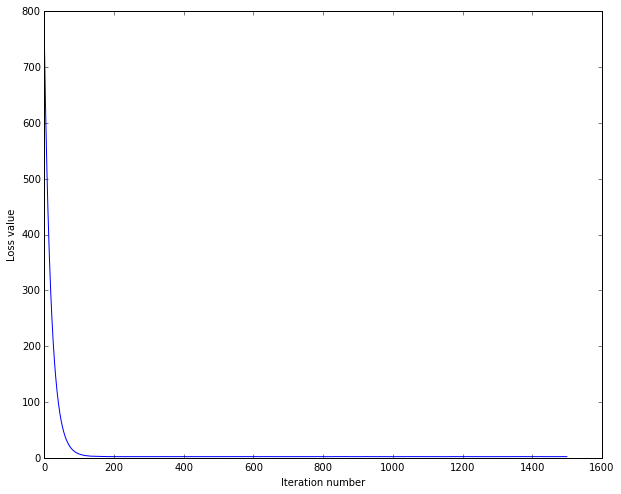

In [11]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [12]:
y_train_pred = softmax.predict(X_train)
print('training accuracy: {:.3%}'.format(np.mean(y_train == y_train_pred)))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {:.3%}'.format(np.mean(y_val == y_val_pred)))

training accuracy: 32.312%
validation accuracy: 34.700%


In [13]:
# evaluate on test set
# Evaluate the best svm on test set
y_test_pred = softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.341000


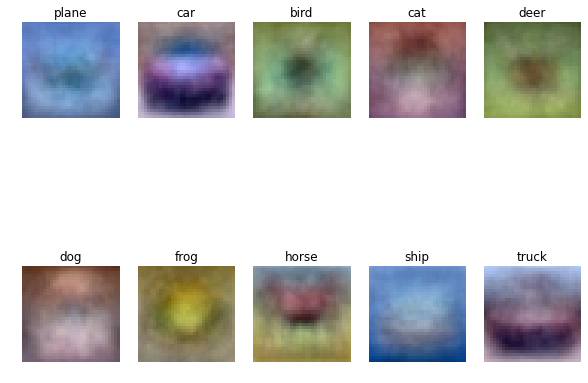

In [14]:
# Visualize the learned weights for each class
w = softmax.W[:,:-1] # strip out the bias
w = w.reshape(10, 32, 32, 3)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

plt.show()